In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus=False)

from matplotlib import rc, font_manager

from sklearn.tree import export_graphviz
import graphviz

import seaborn as sns

In [2]:
df_raw = pd.read_csv("연습_total.csv")

In [3]:
df_raw.head()

,index,환자ID,전방디스크높이(mm),후방디스크높이(mm),지방축적도,Instability,MF + ES,Modic change,PI,PT,...,혈전합병증여부,환자통증정도,흡연여부,통증기간(월),수술기법,수술시간,수술실패여부,수술일자,재발여부,혈액형
0,0,1PT,16.1,12.3,282.3,0,1824.6,3,51.6,36.6,...,0,10,0,1.0,TELD,68.0,0,20190715,0,RH+A
1,1,2PT,13.7,6.4,177.3,0,1737.5,0,40.8,7.2,...,0,10,0,1.0,TELD,31.0,0,20190716,0,RH+A
2,2,3PT,13.6,7.4,256.8,0,1188.5,0,67.5,27.3,...,0,7,0,1.0,TELD,78.0,0,20190731,0,RH+B
3,3,4PT,10.6,7.3,250.1,0,2534.5,0,49.2,18.7,...,0,7,0,2.0,TELD,73.0,0,20190802,0,RH+O
4,4,5PT,17.1,8.1,232.2,0,1840.6,0,58.8,14.7,...,0,7,0,1.0,TELD,29.0,0,20190906,0,RH+A


In [4]:
df_raw.head()

,index,환자ID,전방디스크높이(mm),후방디스크높이(mm),지방축적도,Instability,MF + ES,Modic change,PI,PT,...,혈전합병증여부,환자통증정도,흡연여부,통증기간(월),수술기법,수술시간,수술실패여부,수술일자,재발여부,혈액형
0,0,1PT,16.1,12.3,282.3,0,1824.6,3,51.6,36.6,...,0,10,0,1.0,TELD,68.0,0,20190715,0,RH+A
1,1,2PT,13.7,6.4,177.3,0,1737.5,0,40.8,7.2,...,0,10,0,1.0,TELD,31.0,0,20190716,0,RH+A
2,2,3PT,13.6,7.4,256.8,0,1188.5,0,67.5,27.3,...,0,7,0,1.0,TELD,78.0,0,20190731,0,RH+B
3,3,4PT,10.6,7.3,250.1,0,2534.5,0,49.2,18.7,...,0,7,0,2.0,TELD,73.0,0,20190802,0,RH+O
4,4,5PT,17.1,8.1,232.2,0,1840.6,0,58.8,14.7,...,0,7,0,1.0,TELD,29.0,0,20190906,0,RH+A


통증정도
척추측만증 의심/비의심
척추후만증 의심/비의심

위험도를 만들기 위해서 디스크 위험 - 통증정도 / 변수들이랑 Tree, 로지스틱 회귀 써서
가장 큰 영향을 주는 변수들이 뭔지 계수를 통해 빼오고
계수들을 가공해서 가중치를 계산해서 위험도를 만들고 군집분석으로 만들고

신규 환자 예측 모델 먼저 돌리기.

위험도를 먼저 구해야함.
예측모델 - 두명씩 나눠서 하기.

의사결정트리 / 랜덤포레스트 / 로지스틱회귀 /// 그래디언트부스팅 /// SVM? feature importance가 안나온다(보류)

In [5]:
df_raw.columns

Index(['index', '환자ID', '전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도', 'Instability',
       'MF + ES', 'Modic change', 'PI', 'PT', 'Seg Angle(raw)', 'Vaccum disc',
       '골밀도', '디스크단면적', '디스크위치', '척추이동척도', '척추전방위증', 'Large Lymphocyte',
       'Location of herniation', 'ODI', '가족력', '간질성폐질환', '고혈압여부', '과거수술횟수',
       '당뇨여부', '말초동맥질환여부', '빈혈여부', '성별', '스테로이드치료', '신부전여부', '신장', '심혈관질환',
       '암발병여부', '연령', '우울증여부', '입원기간', '입원일자', '종양진행여부', '직업', '체중', '퇴원일자',
       '헤모글로빈수치', '혈전합병증여부', '환자통증정도', '흡연여부', '통증기간(월)', '수술기법', '수술시간',
       '수술실패여부', '수술일자', '재발여부', '혈액형'],
      dtype='object')

In [6]:
df_raw.drop(['index', '환자ID','ODI', '전방디스크높이(mm)','후방디스크높이(mm)','디스크위치','척추이동척도','간질성폐질환','고혈압여부','당뇨여부','말초동맥질환여부','빈혈여부','신부전여부','심혈관질환','암발병여부','입원기간','입원일자','종양진행여부','직업','퇴원일자','헤모글로빈수치','혈전합병증여부','수술기법','수술시간','수술실패여부','수술일자','혈액형'], axis=1, inplace=True)

In [7]:
df_raw.head()

,지방축적도,Instability,MF + ES,Modic change,PI,PT,Seg Angle(raw),Vaccum disc,골밀도,디스크단면적,...,성별,스테로이드치료,신장,연령,우울증여부,체중,환자통증정도,흡연여부,통증기간(월),재발여부
0,282.3,0,1824.6,3,51.6,36.6,14.4,0,-1.01,2048.50,...,2,1,163,66,0,60.3,10,0,1.0,0
1,177.3,0,1737.5,0,40.8,7.2,17.8,0,-1.14,1753.10,...,1,1,171,47,0,71.7,10,0,1.0,0
2,256.8,0,1188.5,0,67.5,27.3,10.2,0,-1.77,1749.00,...,1,1,178,39,0,77.1,7,0,1.0,0
3,250.1,0,2534.5,0,49.2,18.7,19.9,0,-1.58,1796.20,...,1,0,174,40,0,74.2,7,0,2.0,0
4,232.2,0,1840.6,0,58.8,14.7,5.2,0,-0.79,2021.48,...,1,1,183,42,0,80.7,7,0,1.0,0


합병증 관련된거 / 디스크 관련 없는거 빼자
간질성
고혈압
당뇨병
말초동맥질환여부
빈혈여부
신부전여부
심혈관
암발생

입원기간
입원일자
종양진행여부
환자 직원
퇴원일자
헤모글로빈
혈전합병증
Y - 주관적 통증

디스크높이 - 전방, 후방 (나중에 파생변수 ..?)
디스크위치
척추이동척도

수술방법
수술시간
수술실패여부
수술일자
신장
연랑
입원일자
체중
퇴원일자
헤모글로빈
통증정도(Y)
혈액형

In [8]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,지방축적도,Instability,MF + ES,Modic change,PI,PT,Seg Angle(raw),Vaccum disc,골밀도,디스크단면적,...,성별,스테로이드치료,신장,연령,우울증여부,체중,환자통증정도,흡연여부,통증기간(월),재발여부
0,282.3,0,1824.6,3,51.6,36.6,14.4,0,-1.01,2048.50,...,2,1,163,66,0,60.3,10,0,1.0,0
1,177.3,0,1737.5,0,40.8,7.2,17.8,0,-1.14,1753.10,...,1,1,171,47,0,71.7,10,0,1.0,0
2,256.8,0,1188.5,0,67.5,27.3,10.2,0,-1.77,1749.00,...,1,1,178,39,0,77.1,7,0,1.0,0
3,250.1,0,2534.5,0,49.2,18.7,19.9,0,-1.58,1796.20,...,1,0,174,40,0,74.2,7,0,2.0,0
4,232.2,0,1840.6,0,58.8,14.7,5.2,0,-0.79,2021.48,...,1,1,183,42,0,80.7,7,0,1.0,0


In [9]:
df_raw_x = df_raw_dummy.drop("환자통증정도", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["환자통증정도"] 

In [10]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (1214, 24)
train data Y size: (1214,)
test data X size: (521, 24)
test data Y size: (521,)


In [11]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.574


In [12]:
tree_uncustomized.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1234,
 'splitter': 'best'}

max depth = 6

In [17]:
train_accuracy = []; test_accuracy = []


para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.469,0.409
1,2,0.472,0.411
2,3,0.488,0.428
3,4,0.504,0.422
4,5,0.530,0.424
5,6,0.559,0.447
6,7,0.602,0.443
7,8,0.650,0.445
8,9,0.706,0.499
9,10,0.758,0.484


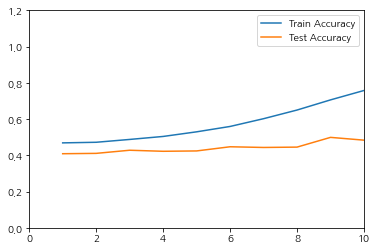

In [18]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="-", label = "Test Accuracy")
plt.xlim([0,10])
plt.ylim([0,1.2])
plt.legend()

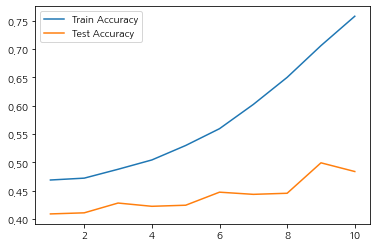

In [19]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="-", label = "Test Accuracy")
plt.legend()

min split = 4

In [22]:
train_accuracy = []; test_accuracy= []

para_split = [n_split for n_split in range(2,11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth = 6, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.559,0.447
1,3,0.558,0.447
2,4,0.558,0.447
3,5,0.558,0.447
4,6,0.558,0.447
5,7,0.558,0.447
6,8,0.554,0.447
7,9,0.554,0.447
8,10,0.553,0.443


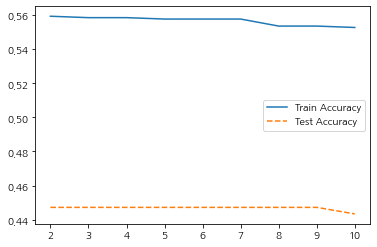

In [23]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

min sample leaf = 2

In [26]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 2 for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split = 4, max_depth = 6, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.556,0.447
1,4,0.550,0.434
2,6,0.550,0.426
3,8,0.548,0.424
4,10,0.554,0.430
5,12,0.545,0.399
6,14,0.548,0.417
7,16,0.540,0.426
8,18,0.535,0.447
9,20,0.530,0.463


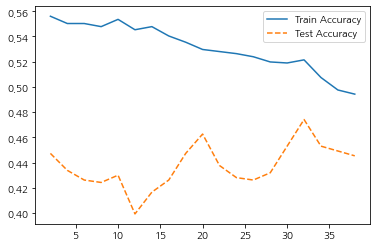

In [27]:
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

tree 모델

In [28]:
tree_final = DecisionTreeClassifier(max_depth = 6, min_samples_split = 4,  min_samples_leaf = 2, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=4,
                       random_state=1234)

In [30]:
v_feature_name = df_train_x.columns

# tree_final.dot으로 결과 저장
export_graphviz(tree_final, out_file="tree_final.dot",feature_names = v_feature_name, impurity = True, filled = True)

# tree_final.dot 그리기
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

UnicodeDecodeError: 'cp949' codec can't decode byte 0xb0 in position 412: illegal multibyte sequence

모델의 평가

In [31]:
y_pred = tree_final.predict(df_test_x) 
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.447

Confusion matrix: 
[[  3   1   0   0   0   0   7   3   0   0]
 [  0  11   0   0   0   0  21   6   0   0]
 [  0   0   0   0   0   0  10   1   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0  13   4   0   0]
 [  0   0   0   0   0   0   9   1   0   0]
 [  1   8   0   0   0   0 186  26   5   1]
 [  0   4   0   0   0   0  91  31   0   1]
 [  0   1   0   0   0   0  34   4   0   0]
 [  0   3   0   0   0   0  30   2   0   2]]


설명변수 중요도

In [36]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
4,PI,0.175
6,Seg Angle(raw),0.144
5,PT,0.132
0,지방축적도,0.113
11,Large Lymphocyte,0.079
9,디스크단면적,0.064
2,MF + ES,0.055
20,체중,0.053
21,흡연여부,0.045
8,골밀도,0.043


In [33]:
#df_importance.sort_values("Importance", ascending=True, inplace = True)
df_importance.head(10)

,Feature,Importance
4,PI,0.174517
6,Seg Angle(raw),0.143905
5,PT,0.131828
0,지방축적도,0.113279
11,Large Lymphocyte,0.079402
9,디스크단면적,0.063681
2,MF + ES,0.054819
20,체중,0.052702
21,흡연여부,0.045162
8,골밀도,0.043485


Text(0, 0.5, '설명변수')

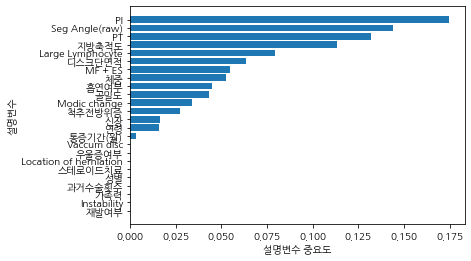

In [34]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

In [35]:
estimator = DecisionTreeClassifier()

# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth, "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}

# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_)) 
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

C:\Users\seony\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


best estimator model: 
DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

best parameter: 
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

best score: 
0.505


y - 연속형 상관분석
/ correlation
(pearson 분석)

y - 범주형 상관분석
: 찾아보고 하기